In [1]:
from IPython.display import display, HTML
display(HTML('<style>pre { white-space: pre !important; }</style>'))

#### helper function for showing info:

In [2]:
from pyspark.sql import DataFrame

def show_df_info(df: DataFrame, num_rows: int = 5):
    row_count = df.count()
    print(f"Number of rows: {row_count}")
    df.show(num_rows)


# <center> Warm-up! <center>

#### Step1: read the csv file

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import year, month, min, max, mean, stddev

spark = SparkSession.builder \
    .appName("StockAnalysis") \
    .getOrCreate()

df = spark.read.csv("stocks.csv", header=True, inferSchema=True)


24/04/17 18:31:06 WARN Utils: Your hostname, marzieh-ZenBook-UX363EA-UX363EA resolves to a loopback address: 127.0.1.1; using 192.168.1.159 instead (on interface wlo1)
24/04/17 18:31:06 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/17 18:31:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


#### Step2: Schema of data

In [4]:
df.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Volume: integer (nullable = true)
 |-- Adj Close: double (nullable = true)



#### Step 3: Showing opening, closing and volume of Records with closing price less than 500

In [5]:
df_less_than_500 = df.filter(df["Close"] < 500).select("Open", "Close", "Volume")
show_df_info(df_less_than_500)

Number of rows: 1359
+----------+------------------+---------+
|      Open|             Close|   Volume|
+----------+------------------+---------+
|213.429998|        214.009998|123432400|
|214.599998|        214.379993|150476200|
|214.379993|        210.969995|138040000|
|    211.75|            210.58|119282800|
|210.299994|211.98000499999998|111902700|
+----------+------------------+---------+
only showing top 5 rows



#### Step 4: Records with opening price more than 200 and closing price less than 200

In [6]:
df_open_more_200_close_less_200 = df.filter((df["Open"] > 200) & (df["Close"] < 200))
show_df_info(df_open_more_200_close_less_200)

Number of rows: 3
+----------+------------------+----------+----------+----------+---------+------------------+
|      Date|              Open|      High|       Low|     Close|   Volume|         Adj Close|
+----------+------------------+----------+----------+----------+---------+------------------+
|2010-01-22|206.78000600000001|207.499996|    197.16|    197.75|220441900|         25.620401|
|2010-01-28|        204.930004|205.500004|198.699995|199.289995|293375600|25.819922000000002|
|2010-01-29|        201.079996|202.199995|190.250002|192.060003|311488100|         24.883208|
+----------+------------------+----------+----------+----------+---------+------------------+



#### Step 5: Extract year from date and save it in a new column

In [7]:
df_with_year = df.withColumn("Year", year("Date"))
show_df_info(df_with_year)

Number of rows: 1762
+----------+----------+----------+------------------+------------------+---------+------------------+----+
|      Date|      Open|      High|               Low|             Close|   Volume|         Adj Close|Year|
+----------+----------+----------+------------------+------------------+---------+------------------+----+
|2010-01-04|213.429998|214.499996|212.38000099999996|        214.009998|123432400|         27.727039|2010|
|2010-01-05|214.599998|215.589994|        213.249994|        214.379993|150476200|27.774976000000002|2010|
|2010-01-06|214.379993|    215.23|        210.750004|        210.969995|138040000|27.333178000000004|2010|
|2010-01-07|    211.75|212.000006|        209.050005|            210.58|119282800|          27.28265|2010|
|2010-01-08|210.299994|212.000006|209.06000500000002|211.98000499999998|111902700|         27.464034|2010|
+----------+----------+----------+------------------+------------------+---------+------------------+----+
only showing top

#### Step 6: Minimum volumes traded for each year

In [8]:
min_volume_per_year = df_with_year.groupBy("Year").agg(min("Volume").alias("minVolume"))
show_df_info(min_volume_per_year, 7)

Number of rows: 7
+----+---------+
|Year|minVolume|
+----+---------+
|2015| 13046400|
|2013| 41888700|
|2014| 14479600|
|2012| 43938300|
|2016| 11475900|
|2010| 39373600|
|2011| 44915500|
+----+---------+



#### Step 7: Highest low price for each year and month

In [9]:
max_low_price_per_year_month = df_with_year.groupBy("Year", month("Date").alias("Month")) \
    .agg(max("Low").alias("maxLow"))
show_df_info(max_low_price_per_year_month)

Number of rows: 84
+----+-----+----------+
|Year|Month|    maxLow|
+----+-----+----------+
|2012|   10|665.550026|
|2010|    7|260.300003|
|2010|   12|325.099991|
|2015|    2|131.169998|
|2014|    4|589.799988|
+----+-----+----------+
only showing top 5 rows



#### Step 8: Mean and standard deviation of high price

In [10]:
mean_high_price = df.agg(mean("High").alias("MeanHighPrice")).collect()[0]["MeanHighPrice"]
stddev_high_price = df.agg(stddev("High").alias("StddevHighPrice")).collect()[0]["StddevHighPrice"]
print(f"Mean High Price: {mean_high_price:.2f}")
print(f"Standard Deviation of High Price: {stddev_high_price:.2f}")

# Stop SparkSession
spark.stop()


Mean High Price: 315.91
Standard Deviation of High Price: 186.90


# <center>Main Task</center>

In [11]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import min, max, mean, stddev

spark = SparkSession.builder \
    .appName("SpotifyAnalysis") \
    .getOrCreate()
df = spark.read.load("spotify.parquet")

In [12]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- album: string (nullable = true)
 |-- album_id: string (nullable = true)
 |-- artists: string (nullable = true)
 |-- artist_ids: string (nullable = true)
 |-- track_number: long (nullable = true)
 |-- disc_number: long (nullable = true)
 |-- explicit: boolean (nullable = true)
 |-- danceability: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- key: long (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: long (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- duration_ms: long (nullable = true)
 |-- time_signature: double (nullable = true)
 |-- year: long (nullable = true)
 |-- release_date: string (nullable = true)



In [115]:
show_df_info(df,10)

Number of rows: 1204012
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+------------------+------+---+-------------------+----+-----------+-----------------+--------------------+--------+------------------+------------------+-----------+--------------+----+------------+------------------+
|                  id|                name|               album|            album_id|             artists|          artist_ids|track_number|disc_number|explicit|      danceability|energy|key|           loudness|mode|speechiness|     acousticness|    instrumentalness|liveness|           valence|             tempo|duration_ms|time_signature|year|release_date|        duration_m|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+------------------+------+---+-------------------+----+--

#### Change release_date type from string to Date



Since some release dates only contain year or year-month, we replace the missing days and months with 1.

In [14]:
from pyspark.sql.functions import col, when, substring, concat, lit, to_date
from pyspark.sql.types import DateType


df = df.withColumn("release_date",
                   when(col("release_date").rlike('\d{4}-\d{2}-\d{2}'), 
                        to_date(col("release_date"), 'yyyy-MM-dd'))
                   .when(col("release_date").rlike('\d{4}-\d{2}'), 
                        to_date(concat(col("release_date"), lit("-01")), 'yyyy-MM-dd'))
                   .otherwise(to_date(concat(col("release_date"), lit("-01-01")), 'yyyy-MM-dd')))

#### Check for duplicates

In [15]:
original_rows = df.count()
no_duplicates_df = df.dropDuplicates()
if no_duplicates_df.count() < original_rows:
    print("The DataFrame has duplicated rows.")
else:
    print("The DataFrame does not have any duplicated rows.")

24/04/17 18:31:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/04/17 18:31:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/04/17 18:31:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/04/17 18:31:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/04/17 18:31:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/04/17 18:31:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/04/17 18:31:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/04/17 18:31:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/04/17 18:31:22 WARN RowBasedKeyValueBatch: Calling spill() on

The DataFrame does not have any duplicated rows.


#### Check for missing values

In [16]:
from pyspark.sql import Column as Col

from pyspark.sql.functions import col, count

non_missing_values = df.agg(*[count(col(c)).alias(c) for c in df.columns])
print("number of missing values in each column: ")
non_missing_values.show()


number of missing values in each column: 


+-------+-------+-------+--------+-------+----------+------------+-----------+--------+------------+-------+-------+--------+-------+-----------+------------+----------------+--------+-------+-------+-----------+--------------+-------+------------+
|     id|   name|  album|album_id|artists|artist_ids|track_number|disc_number|explicit|danceability| energy|    key|loudness|   mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|duration_ms|time_signature|   year|release_date|
+-------+-------+-------+--------+-------+----------+------------+-----------+--------+------------+-------+-------+--------+-------+-----------+------------+----------------+--------+-------+-------+-----------+--------------+-------+------------+
|1204025|1204022|1204014| 1204025|1204025|   1204025|     1204025|    1204025| 1204025|     1204025|1204025|1204025| 1204025|1204025|    1204025|     1204025|         1204025| 1204025|1204025|1204025|    1204025|       1204025|1204025|     1204025|
+---

there are a a few null values in columns `name` and `album`. But since there are not that many of them, we drop the whole row.

In [17]:
df = df.dropna(how='any')

#### Number of Tracks, Albums, Artists:

In [18]:
total_tracks = df.count()
print("Number of tracks:", total_tracks)
unique_albums = df.select(col("album_id")).distinct().count()
print("Number of unique albums:", unique_albums)
unique_artists = df.select(col("artist_ids")).distinct().count()
print("Number of unique artists:", unique_artists)

24/04/17 18:31:27 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


Number of tracks: 1204012


Number of unique albums: 118381


Number of unique artists: 166420


#### Average Danceability:

In [19]:
from pyspark.sql import functions as F

avg_danceability = df.select(F.avg("danceability")).collect()[0][0]
print(f"The average danceability is {avg_danceability}")

The average danceability is 0.4930547466719647


#### Average Duration:

In [20]:
from pyspark.sql.functions import avg

average_duration = df.select(avg("duration_ms")).collect()[0][0]/1000/60
print("Average duration:", round(average_duration, 2), "minutes")

Average duration: 4.15 minutes


#### Number of Explicit Songs:

In [21]:
num_explicit_songs = df.filter(df["explicit"] == True).count()
num_songs = df.count()
print(f"The number of explicit songs is {num_explicit_songs}")
print(f"The percentage of explicit songs is {num_explicit_songs/num_songs*100}")

The number of explicit songs is 82645
The percentage of explicit songs is 6.8641342445091915


#### Top 10 Artists by Track Count:

In [22]:
artist_track_count = df.groupBy("artists").agg(F.count("*").alias("track_count"))
top_10_artists = artist_track_count.orderBy(F.desc("track_count")).limit(10)
show_df_info(top_10_artists, 10)

Number of rows: 10


+--------------------+-----------+
|             artists|track_count|
+--------------------+-----------+
| ['Various Artists']|       1753|
|['Vitamin String ...|       1577|
| ['Aretha Franklin']|       1209|
|['The City of Pra...|       1042|
|["Dan Gibson's So...|        997|
|       ['Bob Dylan']|        913|
|        ['The Fall']|        812|
|["Pickin' On Seri...|        774|
|    ['Dolly Parton']|        747|
|['Guided By Voices']|        739|
+--------------------+-----------+



#### Top 10 Years by Track Count:

In [23]:
yearly_release_count = df.groupBy("year").agg(F.count("*").alias("release_count"))
top_10_years = yearly_release_count.orderBy(F.desc("release_count")).limit(10)
show_df_info(top_10_years, 10)

Number of rows: 10


+----+-------------+
|year|release_count|
+----+-------------+
|2020|        69715|
|2019|        67276|
|2006|        56945|
|2007|        56287|
|2018|        56167|
|2017|        51308|
|2008|        50475|
|2005|        49977|
|2013|        49048|
|2016|        47427|
+----+-------------+



#### Percentage of Acoustic Tracks:

In [24]:
acoustic_tracks = df.filter(df["acousticness"] >= 0.7).count()
total_tracks = df.count()
percentage_acoustic = (acoustic_tracks / total_tracks) * 100
print(f"The percentage of acoustic tracks is {percentage_acoustic}%")

The percentage of acoustic tracks is 35.96932588711741%


#### Longest Song Duration:

In [25]:
longest_duration = df.select(F.max("duration_ms")).collect()[0][0]
longest_song_duration = int(longest_duration / 1000 / 60)
print(f"The longest song duration is {longest_song_duration} minutes")

The longest song duration is 101 minutes


#### Average danceability, energy, and valence of tracks per album:

In [26]:
avg_stats = df \
    .groupBy("album") \
    .agg({
        'danceability': 'avg',
        'energy': 'avg',
        'valence': 'avg'
     }) \
    .withColumnRenamed("danceability", "avg_danceability") \
    .withColumnRenamed("energy", "avg_energy") \
    .withColumnRenamed("valence", "avg_valence")
show_df_info(avg_stats, 10)

Number of rows: 106161


+--------------------+-------------------+-------------------+------------------+
|               album|       avg(valence)|  avg(danceability)|       avg(energy)|
+--------------------+-------------------+-------------------+------------------+
|        Seafieldroad|0.19806249999999997|           0.425875|0.3587499999999999|
|  Hunter Hayes: Live|             0.5506|             0.3468|            0.7618|
|     U Hate 2 See It|0.36233333333333334|             0.6945|0.7731666666666667|
|The Chocolate Whe...|             0.4058| 0.6224999999999999|            0.9437|
|            Duotones| 0.5317000000000001|             0.5876|            0.4585|
|            The City|0.47279999999999994|             0.6285|0.7254545454545455|
|                Silk| 0.3791205882352941| 0.6497058823529411|0.5581264705882354|
|   Piano Starts Here| 0.5945384615384616|0.45607692307692305|0.3477692307692308|
|Back On The Bus, ...|              0.351|0.34612499999999996|          0.463375|
|Thotiana (feat.

#### Top 10 Most Danceable Albums by Average Danceability:

In [27]:
result = avg_stats.groupBy("album").agg(F.max("avg(danceability)").alias("danceability"))
result = result.orderBy(F.desc("danceability")).limit(10)
show_df_info(result, 10)

Number of rows: 10


+--------------------+------------+
|               album|danceability|
+--------------------+------------+
| Techno Is Not Fault|       0.992|
|Blurred Lines Parody|       0.984|
|             Patapon|       0.984|
|          Full Power|        0.98|
|  Dancing in My Room|        0.98|
|            Stick Up|       0.977|
|        Look At That|       0.977|
|         Uno (Remix)|       0.975|
|              Acterz|       0.974|
|         Booska'Sten|       0.972|
+--------------------+------------+



#### Top 10 Most Energetic Albums by Average Energy:

In [28]:
result = avg_stats.groupBy("album").agg(F.max("avg(energy)").alias("energy"))
result = result.orderBy(F.desc("energy")).limit(10)
show_df_info(result, 10)

Number of rows: 10


+--------------------+------------------+
|               album|            energy|
+--------------------+------------------+
|Wind Chime Waterfall|               1.0|
|          Bitter Boy|0.9993333333333334|
|    Final Stop Death|             0.999|
|    Black Moldy Brew|             0.999|
|      Babbling Brook|             0.999|
|      Härd Sweetcöre|             0.999|
|Booty of Mass Des...|             0.999|
|       Astral Sounds|             0.999|
|          Spark Plug|             0.999|
|          Hammergeil|             0.999|
+--------------------+------------------+



#### Average tempo and duration of tracks for each artist.:

In [125]:
jsoned_df = df.withColumn("artists_list",F.from_json("artists", "ARRAY<STRING>"))

In [126]:
df_exp = jsoned_df.withColumn("artist", F.explode("artists_list"))
avg_stats = df_exp \
.groupBy('artist') \
.agg({'tempo': 'mean', 'duration_ms': 'mean'}) \
.withColumnRenamed('avg(tempo)', 'avg_tempo') \
.withColumnRenamed('avg(duration_ms)', 'avg_duration')

show_df_info(avg_stats, 20)

Number of rows: 137413


+--------------------+------------------+------------------+
|              artist|      avg_duration|         avg_tempo|
+--------------------+------------------+------------------+
|               Rufio| 182662.7659574468| 126.8248723404255|
|        Seafieldroad|        219468.125|111.44862499999999|
|              *NSYNC|       236990.4125|115.05203749999995|
|       Iain Burnside|167983.80392156861|108.82860784313722|
|Ann Marie Yasinitsky|          684600.0|            85.676|
|       Andrew Tuttle|         310387.75|106.07674999999999|
|     Katherine Bryan|402506.87096774194| 91.73506451612904|
|     Johannes Brahms|344452.70396270393|100.34420279720275|
|              Prolix|       273683.9375|169.14249999999996|
|        Tony Smalios|          256520.0|          93.45075|
|        Ziggy Marley|         239033.25|         107.43575|
|           Xperience|205874.72222222222| 96.38172222222221|
|               Jok3r|          149786.0|           117.021|
|Anne, Anniina & A...|  

#### Artist with the most explicit tracks:

In [127]:
counted_explicit_tracks = df_exp.filter(df_exp["explicit"] == True).groupBy('artist').count().withColumnRenamed('count', 'num_explicit_tracks')
top_artist = counted_explicit_tracks.orderBy(F.desc("num_explicit_tracks"), F.asc("artist")).limit(1)
top_artist.show()

+---------------+-------------------+
|         artist|num_explicit_tracks|
+---------------+-------------------+
|Grant Macdonald|                561|
+---------------+-------------------+



#### Artist with the most diverse set of albums

In [128]:
result = df_exp \
    .groupBy("artist") \
    .agg(F.countDistinct("album_id").alias("num_distinct_albums"))

# Find the artist with the maximum number of distinct albums
max_diverse_artist = result \
    .orderBy(F.desc("num_distinct_albums")) \
    .limit(1) \
    .select("artist") \
    .collect()[0][0]

print(f"The artist with the most diverse set of albums is {max_diverse_artist}")

The artist with the most diverse set of albums is Johann Sebastian Bach


In [34]:
pip install pyspark_dist_explore

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 2.5 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 2.9 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 KB 2.3 MB/s eta 0:00:002.4 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


#### Distribution of tracks over the years

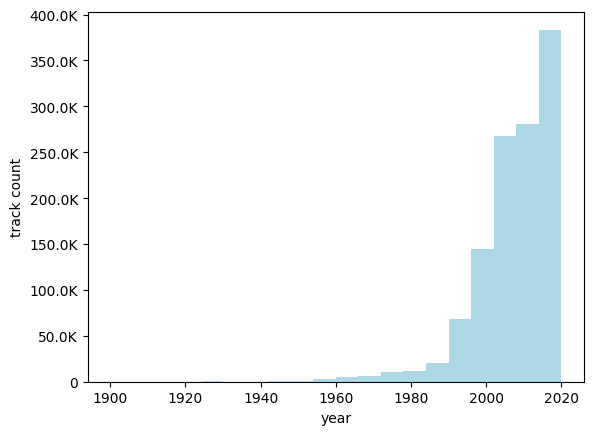

In [47]:
from pyspark_dist_explore import hist
import matplotlib.pyplot as plt
df_recent_years = df.filter(df["year"] > 1750)
fig, ax = plt.subplots()
plt.xlabel("year")
plt.ylabel("track count")
hist(ax, df_recent_years.select('year'), bins = 20, color=['lightblue'])
plt.show()

#### Distribution of tracks durations

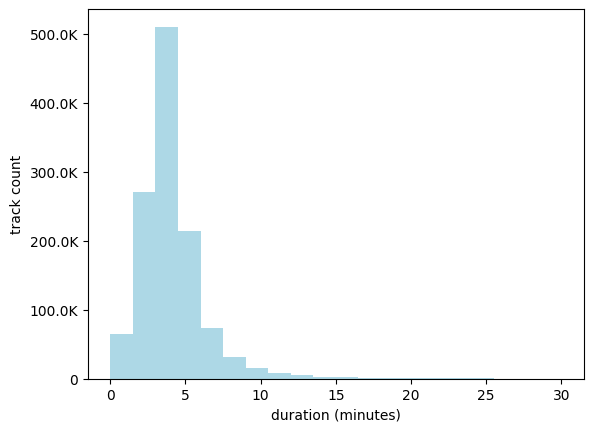

In [51]:
df = df.withColumn('duration_m', F.col('duration_ms') / (1000*60))
df_small_duration = df.filter(df["duration_m"] < 30)
fig, ax = plt.subplots()
plt.xlabel("duration (minutes)")
plt.ylabel("track count")
hist(ax, df_small_duration.select('duration_m'), bins = 20, color=['lightblue'])
plt.show()

As you can see the majority of tracks are less than 6 minutes.

#### Correlation between loudness and energy

In [52]:
correlation = df.stat.corr('loudness', 'energy')
print(f"Correlation between Loudness and Energy: {correlation}")

Correlation between Loudness and Energy: 0.8179328879011405


As you can see there is a quite high correlation between `loudness` and `energy`

#### distribution of explicit tracks across different time periods.

In [83]:
explicit_counts = df.filter(df["explicit"] == True).groupBy("year").count().withColumnRenamed('count', 'exp_count')
non_explicit_counts = df.filter(df["explicit"] == False).groupBy("year").count().withColumnRenamed('count', 'non_exp_count')


result = explicit_counts.join(non_explicit_counts, on=["year"], how="outer") \
    .selectExpr("year", "coalesce(exp_count, 0) + coalesce(non_exp_count, 0) as total_count", "coalesce(exp_count, 0) as explicit_count") \
    .withColumn("percentage", F.col("explicit_count") / F.col("total_count") * 100)

show_df_info(result, 100)

Number of rows: 101


+----+-----------+--------------+-------------------+
|year|total_count|explicit_count|         percentage|
+----+-----------+--------------+-------------------+
|   0|         10|             0|                0.0|
|1900|         14|             0|                0.0|
|1908|         19|             0|                0.0|
|1909|         25|             0|                0.0|
|1917|         52|             0|                0.0|
|1920|         25|             0|                0.0|
|1923|         50|             0|                0.0|
|1924|         36|             0|                0.0|
|1925|         49|             0|                0.0|
|1926|        107|             0|                0.0|
|1927|         48|             0|                0.0|
|1928|        114|             0|                0.0|
|1929|         32|             0|                0.0|
|1930|         59|             0|                0.0|
|1931|         35|             0|                0.0|
|1932|         59|          

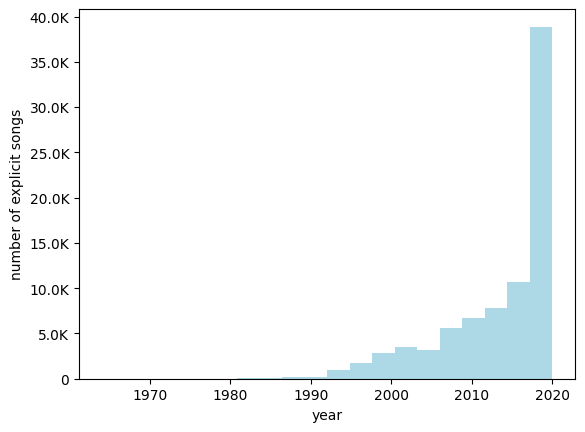

In [80]:
explicit_counts = df.filter(df["explicit"] == True)
fig, ax = plt.subplots()
plt.xlabel("year")
plt.ylabel("number of explicit songs")
hist(ax, explicit_counts.select('year'), bins = 20, color=['lightblue'])
plt.show()

#### Loudness Over Time

In [85]:
average_loudness_df = df.groupBy("year") \
                        .agg({'loudness': 'mean'}) \
                        .orderBy('year')

show_df_info(average_loudness_df, 20)

Number of rows: 101


+----+-------------------+
|year|      avg(loudness)|
+----+-------------------+
|   0|           -14.8162|
|1900|-18.077785714285717|
|1908|-15.401263157894741|
|1909|-12.401080000000002|
|1917|-16.892826923076928|
|1920|          -12.68692|
|1923|-13.599960000000005|
|1924|-11.583305555555553|
|1925|-15.291244897959185|
|1926|-14.683813084112153|
|1927|-13.589187500000001|
|1928| -12.34871052631579|
|1929|       -11.25565625|
|1930|-11.086830508474577|
|1931|-13.341199999999999|
|1932|-13.422423728813563|
|1933|-12.582269841269843|
|1935|          -10.74955|
|1936| -13.20774698795181|
|1937|-13.216875000000002|
+----+-------------------+
only showing top 20 rows



# <center>Questions</center>

### 1. how Spark and Hadoop work. What does the term ‘lazy evaluation’ mean for them? Explain with a simple example.

#### Hadoop and Spark Comparison

##### Hadoop
- Utilizes HDFS for distributed storage and MapReduce for distributed processing.
- Well-suited for batch processing of large datasets but can be less efficient for iterative or interactive workloads.

##### Spark
- Employs in-memory computing and offers various APIs including RDDs, Spark SQL, Spark Streaming, MLlib, and GraphX.
- Faster and more versatile than Hadoop, suitable for a wide range of use cases including batch processing, real-time processing, iterative algorithms, and interactive data analysis.

#### Lazy Evaluation in Spark and Hadoop

In the context of Spark and Hadoop, lazy evaluation means that transformations on data are not immediately executed. Instead, they are stored as a series of transformations to be performed later, when an action is called. This allows for optimization of the computation process.

For example, in Spark, if you have a dataset and you apply multiple transformations like filtering, mapping, and aggregating, Spark won't execute these transformations immediately. It will wait until an action like collect() or show() is called. This deferred execution helps Spark optimize the computation by combining multiple transformations and executing them in an efficient manner.

### 2. Your main task’s dataset has about 1,200,000 rows, which makes it quite hard, and even sometimes impossible, to work with. Explain how parquet files try to solve this problem, compared to normal file formats like csv.

#### Advantages of Parquet Files

##### Columnar Storage
- Parquet files store data in a columnar format, storing each column separately.
- Enables efficient compression and encoding techniques on a per-column basis, reducing storage space compared to row-based formats like CSV.

##### Predicate Pushdown
- Parquet files support predicate pushdown, reading only necessary columns and rows based on query predicates.
- Reduces I/O overhead and improves query performance, especially for selective queries.

##### Schema Evolution
- Parquet files include metadata describing the data schema, allowing for schema evolution without compatibility issues.
- New columns can be added or existing columns modified without rewriting the entire dataset.

##### Compression
- Parquet files support various compression algorithms such as Snappy, GZIP, and LZ4.
- Compression techniques reduce storage footprint and improve read/write performance.

##### Partitioning
- Parquet files can be partitioned based on one or more columns.
- Improves query performance by enabling partition pruning, scanning only relevant partitions during query execution.

Overall, Parquet files offer significant advantages over traditional file formats like CSV when working with large datasets, making them a preferred choice for big data processing frameworks.

### 3. Sparkdoesn’tsavecheckpoints.How can we enforce it to do so?

#### Enable Checkpointing

Before using checkpointing in Spark, you need to enable it by setting the checkpoint directory using the SparkContext.setCheckpointDir() method. Ensure that this directory is accessible by all nodes in the Spark cluster.

In [ ]:
sc.setCheckpointDir("hdfs://path/to/checkpoint/dir")

#### Perform Checkpointing

Once checkpointing is enabled in Spark, you can enforce it on an RDD or DataFrame by calling the checkpoint() method. This action triggers the execution of the computation graph up to that point and saves the intermediate results to the checkpoint directory.

In [ ]:
rdd.checkpoint()
df.checkpoint()

### 4. Top companies stream their data on a regular routine, e.g. daily. How can we save data, so that we could filter it based on specific columns, e.g. date, faster than regular filtering?

#### Partitioning by Date

If you're streaming data on a daily basis, you can partition the data by date. Each day's data can be saved in a separate directory or file, with the directory or file name representing the date. This allows for fast filtering based on the date column, as Spark or any other processing framework can directly access the relevant partition containing the data for the desired date.

#### File Formats

Choose a file format that supports partitioning efficiently, such as Parquet. Parquet files can be partitioned based on one or more columns, enabling efficient pruning of irrelevant partitions during query execution.

#### Optimized Storage

Ensure that the data is stored in a distributed file system like HDFS or an object store like Amazon S3. This ensures that the data is distributed across multiple nodes, allowing for parallel processing and faster retrieval.

#### Optimize for Query Patterns

Analyze the typical query patterns and partition the data accordingly. For example, if filtering by date is the most common operation, partitioning by date would be beneficial. Similarly, if filtering by another column is more common, consider partitioning by that column instead.

### 5.  Let's face off Pandas and PySpark in the data analysis arena! When does each library truly shine, and why?

#### Pandas vs. PySpark: A Comparative Analysis

##### Data Size

- Pandas: Best suited for working with small to medium-sized datasets that can fit into memory. It performs well when the dataset fits comfortably on a single machine.
- PySpark: Designed for handling large-scale datasets that exceed the memory capacity of a single machine. PySpark distributes the data across a cluster of machines, allowing for processing of massive datasets that cannot be handled by Pandas alone.

##### Processing Complexity

- Pandas: Ideal for complex data manipulation and analysis tasks due to its rich set of functions and expressive syntax. It offers a wide range of operations for data cleaning, transformation, and analysis, making it suitable for intricate data processing workflows.
- PySpark: Well-suited for processing complex data transformations and analytics at scale. PySpark leverages distributed computing to handle complex operations on large datasets efficiently. It excels in scenarios where processing complexity is high and parallel processing is necessary for timely analysis.

##### User Experience

- Pandas: Offers a user-friendly and intuitive interface, making it easy for data analysts and scientists to perform exploratory data analysis and build models. Pandas' syntax is concise and familiar to Python users, which contributes to its popularity and ease of use.
- PySpark: Requires a deeper understanding of distributed computing concepts and Spark's API. While PySpark provides similar functionality to Pandas, transitioning from Pandas to PySpark may require some learning curve, especially for users unfamiliar with distributed computing paradigms. However, once users are comfortable with Spark's API, they can leverage its scalability and performance benefits.